In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

In [2]:
sr = 25
times = np.arange(0,32,1, dtype=float)*sr

In [3]:
READ_PATHS = ['/Users/lukepolson/Documents/test_data/pulse_347848/',
              '/Users/lukepolson/Documents/test_data/pulse_347935/',
              '/Users/lukepolson/Documents/test_data/pulse_348061/']

In [4]:
COLUMNS = ['RunNumber','LBNumber',  'EventNumber','BCID','LArError','ncells', 'ECell',
            'TCell', 'EtaCell', 'PhiCell', 'LayerCell','ProvCell', 'QuaCell','GainCell',
            'HwidCell','ADC',]

7791 and 26323 are identification numbers of the cells.

In [5]:
HW_IDs = [61040]
DFS = [pd.DataFrame(columns=COLUMNS)]*len(HW_IDs)
DFS_DICT = dict(zip(HW_IDs, DFS))

# This is the Code that Works

In [6]:
for READ_PATH in READ_PATHS:
    for (i,filename) in enumerate(os.listdir(READ_PATH)):
        if(i%30==0): print(i) 
        if filename.endswith(".pkl"):
            opened_df = pd.read_pickle(READ_PATH+filename)
            for HW_ID in HW_IDs:
                DFS_DICT[HW_ID] = DFS_DICT[HW_ID].append(opened_df[opened_df['HwidCell']==HW_ID])
        del(opened_df)

0
30
60
90
120
150
180
210
240
270
300
330
360
390
420
450
480
510
540
570
0
30
60
90
120
150
180
210
240
270
300
330
360
390
420
450
480
0
30
60
90
120
150
180
210
240
270
300


In [8]:
def get_lag_time_col(row):
    if row['RunNumber'] == 347848:
        if (row['LBNumber']>=157 and row['LBNumber']<=189):
            return 0
        elif (row['LBNumber']>=190 and row['LBNumber']<=252):
            return 12.5
        elif (row['LBNumber']>=253 and row['LBNumber']<=284):
            return 6.25
        elif (row['LBNumber']>=285 and row['LBNumber']<=313):
            return 18.75
        elif (row['LBNumber']>=315 and row['LBNumber']<=347):
            return 3.125
        elif (row['LBNumber']>=349 and row['LBNumber']<=398):
            return 21.875
        elif (row['LBNumber']>=399 and row['LBNumber']<=420):
            return 12.5
        else:
            return 1000
        
    if row['RunNumber'] == 347935:
        if (row['LBNumber']>=1 and row['LBNumber']<=820):
            return 0
        elif (row['LBNumber']>=822 and row['LBNumber']<=852):
            return 12.5
        elif (row['LBNumber']>=854 and row['LBNumber']<=882):
            return 21.875
        elif (row['LBNumber']>=885 and row['LBNumber']<=910):
            return 3.125
        elif (row['LBNumber']>=912 and row['LBNumber']<=1013):
            return 18.75
        else:
            return 1000
        
    if row['RunNumber'] == 348061:
        if (row['LBNumber']>=1 and row['LBNumber']<=992):
            return 9.375
        elif (row['LBNumber']>=994):
            return 15.625
        else:
            return 1000
    
        

In [9]:
for key in DFS_DICT:
    DFS_DICT[key]['LagTime'] = DFS_DICT[key].apply(get_lag_time_col, axis=1)

In [33]:
for key in DFS_DICT:
    DFS_DICT[key].to_pickle('Cells/df_cell_{}.pkl'.format(key))

In [30]:
df = DFS_DICT[61040]
ADC = df[df['ECell']>20000].iloc[0]['ADC']
EE = df[df['ECell']>20000].iloc[0]['ECell']
tt = times + df[df['ECell']>20000].iloc[0]['TCell']

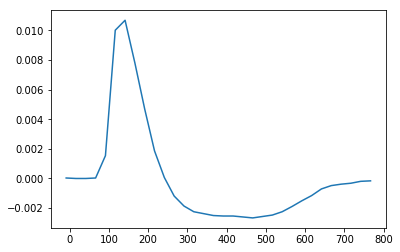

In [32]:
plt.plot(tt, ADC/EE)

# Not Weighted By Energy

In [ ]:
tt = np.arange(0, 32*sr+max(DFS_DICT[505]['LagTime']), 3.125)
histo_df = pd.DataFrame(columns=list(tt))

for index, row in DFS_DICT[505].iterrows():
    t = list(times + row['LagTime'])
    new_row = row['ADC']/row['ECell']
    histo_df = histo_df.append(dict(zip(t, new_row)), ignore_index=True)
    
histo_df_d = histo_df.describe()

In [ ]:
weights = np.array(DFS_DICT[505]['ECell'])

In [ ]:
df2 = histo_df.where(pd.isnull,1).mul(weights, axis='rows')
df2 = df2.multiply(1 / df2.sum(axis=0), axis=1)
df2.head()

In [ ]:
ser1 = pd.Series(histo_df_d.T['mean'])

fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.scatter(ser1.index, ser1)
ax.grid()
ax.set_xlabel('Time (ns)')
plt.show()

# Weighted By Energy

In [ ]:
tt = np.arange(0, 32*sr+max(DFS_DICT[505]['LagTime']), 3.125)
histo_df = pd.DataFrame(columns=list(tt))

for index, row in DFS_DICT[505].iterrows():
    t = list(times + row['LagTime'])
    new_row = row['ADC']/row['ECell']
    histo_df = histo_df.append(dict(zip(t, new_row)), ignore_index=True)

weighted = True
if weighted:
    w_df = histo_df.where(pd.isnull,1).mul(weights, axis='rows')
    w_df = w_df.multiply(1 / w_df.sum(axis=0), axis=1)
    std_corr1 = w_df.sum(axis=0)**2; std_corr2 = (w_df**2).sum(axis=0)
    w_df = w_df.mul(w_df.describe().T['count'], axis=1)
    
histo_df = (histo_df * w_df).describe()
histo_df = histo_df.append(pd.Series(std_corr1/std_corr2, name='mean_std_corr'))
histo_df = histo_df.append(pd.Series(histo_df.T['std']/np.sqrt(histo_df.T['mean_std_corr']), name='std_mean'))

In [ ]:
histo_df

In [ ]:
ser2 = pd.Series(histo_df.T['mean'])
ser_err = pd.Series(histo_df.T['std_mean'])

fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.errorbar(ser2.index, ser2, ser_err, c='k')
ax.scatter(ser2.index, ser2)
ax.grid()
ax.set_xlabel('Time (ns)')
plt.show()

# Comparison

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
ax.scatter(ser1.index, ser1, s=2)
ax.scatter(ser2.index, ser2, s=2)
ax.grid()

In [ ]:
READ_PATH_TEST = '/Users/lukepolson/Documents/test_data/pulse_347848/DF1.pkl'
opened_df = pd.read_pickle(READ_PATH_TEST)